# Question 3
1.   Full Name: Farhad Fallah 
2.   Student Number: 97102214

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader ,Dataset 
import string
from collections import OrderedDict
import numpy as np

In [2]:
df_train = pd.read_csv('HW2_data\Q3_train.csv')
df_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


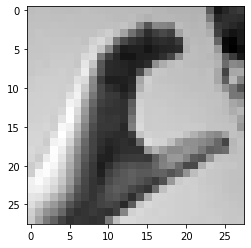

In [3]:
train = df_train.to_numpy() 
train.shape
data = train[2,1:].reshape(28,28)
plt.imshow(data,cmap='gray')


In [4]:
st = string.ascii_lowercase
odict = OrderedDict()
mydict = {}
for i,s in enumerate(st):
    mydict[i] = s


## Part 1
### displaying 9 random images with their labels

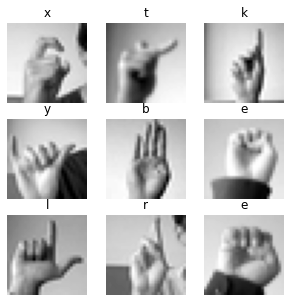

In [5]:
fig, ax = plt.subplots(3,3 , figsize =(5,5))

a = np.random.randint(len(train),size=9)

sample = train[a,:]
for i,row in enumerate(sample):
    label = mydict[row[0]]
    img = row[1:].reshape(28,28)
    plt.subplot(3,3,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(label)
    plt.axis('off')

## Part 2
#### at first we define our dataset and nerual network structure 
#### then we choose our optimizer, one time train our model with SGD and then try Adam
#### as we can see in results we reached  more accuracy in less epochs when we used Adam.

In [6]:
class CustomDataset(Dataset):
    def __init__(self, train, transform=None, target_transform=None):
        #df = pd.read_csv(annotations_file)
        self.labels = torch.tensor(train[:,0])
        self.features = torch.tensor(train[:,1:])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        feature = self.features[idx,:]
        label = self.labels[idx]
        if self.transform:
            feature = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return feature, label

In [7]:
training_rate = 0.8
train_data = CustomDataset(train[0:int(training_rate * len(train))])
val_data = CustomDataset(train[int(training_rate * len(train)):])
print(len(train_data) , len(val_data))

21964 5491


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 25),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        #y_pred = logits.argmax(dim=1)
        return logits

In [10]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=25, bias=True)
    (7): Softmax(dim=1)
  )
)


In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        #print(y.shape)
        X = X.float()
        pred = model(X)
        
        #print(pred)
        #print(type(y))
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.float()
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
batch_size = 100
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
epochs = 400
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 3.231572  [    0/21964]
loss: 3.208072  [ 5000/21964]
loss: 3.113997  [10000/21964]
loss: 3.135655  [15000/21964]
loss: 3.116054  [20000/21964]
Test Error: 
 Accuracy: 18.4%, Avg loss: 3.112272 

Epoch 2
-------------------------------
loss: 3.114867  [    0/21964]
loss: 3.172269  [ 5000/21964]
loss: 3.069210  [10000/21964]
loss: 3.184251  [15000/21964]
loss: 3.043111  [20000/21964]
Test Error: 
 Accuracy: 23.3%, Avg loss: 3.065649 

Epoch 3
-------------------------------
loss: 3.139724  [    0/21964]
loss: 3.109845  [ 5000/21964]
loss: 3.061316  [10000/21964]
loss: 3.051459  [15000/21964]
loss: 3.061553  [20000/21964]
Test Error: 
 Accuracy: 23.8%, Avg loss: 3.050256 

Epoch 4
-------------------------------
loss: 3.063191  [    0/21964]
loss: 3.066593  [ 5000/21964]
loss: 3.083307  [10000/21964]
loss: 3.067957  [15000/21964]
loss: 3.075191  [20000/21964]
Test Error: 
 Accuracy: 24.1%, Avg loss: 3.054752 

Epoch 5
------------------------

Test Error: 
 Accuracy: 33.8%, Avg loss: 2.949026 

Epoch 35
-------------------------------
loss: 2.938175  [    0/21964]
loss: 2.988118  [ 5000/21964]
loss: 2.909990  [10000/21964]
loss: 2.909602  [15000/21964]
loss: 2.922662  [20000/21964]
Test Error: 
 Accuracy: 34.0%, Avg loss: 2.944954 

Epoch 36
-------------------------------
loss: 3.017778  [    0/21964]
loss: 2.952032  [ 5000/21964]
loss: 3.029471  [10000/21964]
loss: 3.059601  [15000/21964]
loss: 2.969605  [20000/21964]
Test Error: 
 Accuracy: 33.9%, Avg loss: 2.945296 

Epoch 37
-------------------------------
loss: 2.925529  [    0/21964]
loss: 2.983582  [ 5000/21964]
loss: 2.888410  [10000/21964]
loss: 2.989375  [15000/21964]
loss: 2.958378  [20000/21964]
Test Error: 
 Accuracy: 34.1%, Avg loss: 2.942191 

Epoch 38
-------------------------------
loss: 2.922944  [    0/21964]
loss: 3.038594  [ 5000/21964]
loss: 2.910111  [10000/21964]
loss: 2.896136  [15000/21964]
loss: 2.901203  [20000/21964]
Test Error: 
 Accuracy: 34.0

loss: 2.814534  [15000/21964]
loss: 2.866592  [20000/21964]
Test Error: 
 Accuracy: 46.7%, Avg loss: 2.819075 

Epoch 69
-------------------------------
loss: 2.805330  [    0/21964]
loss: 2.824183  [ 5000/21964]
loss: 2.870671  [10000/21964]
loss: 2.901091  [15000/21964]
loss: 2.842489  [20000/21964]
Test Error: 
 Accuracy: 46.7%, Avg loss: 2.818499 

Epoch 70
-------------------------------
loss: 2.883023  [    0/21964]
loss: 2.786233  [ 5000/21964]
loss: 2.774708  [10000/21964]
loss: 2.802916  [15000/21964]
loss: 2.815097  [20000/21964]
Test Error: 
 Accuracy: 46.7%, Avg loss: 2.817022 

Epoch 71
-------------------------------
loss: 2.862158  [    0/21964]
loss: 2.762586  [ 5000/21964]
loss: 2.903108  [10000/21964]
loss: 2.804833  [15000/21964]
loss: 2.828205  [20000/21964]
Test Error: 
 Accuracy: 46.7%, Avg loss: 2.816478 

Epoch 72
-------------------------------
loss: 2.784041  [    0/21964]
loss: 2.802330  [ 5000/21964]
loss: 2.833432  [10000/21964]
loss: 2.863770  [15000/21964

loss: 2.833530  [ 5000/21964]
loss: 2.882855  [10000/21964]
loss: 2.781440  [15000/21964]
loss: 2.784547  [20000/21964]
Test Error: 
 Accuracy: 50.4%, Avg loss: 2.779615 

Epoch 103
-------------------------------
loss: 2.814541  [    0/21964]
loss: 2.802546  [ 5000/21964]
loss: 2.842551  [10000/21964]
loss: 2.842002  [15000/21964]
loss: 2.752487  [20000/21964]
Test Error: 
 Accuracy: 50.4%, Avg loss: 2.779235 

Epoch 104
-------------------------------
loss: 2.766874  [    0/21964]
loss: 2.785306  [ 5000/21964]
loss: 2.861473  [10000/21964]
loss: 2.880366  [15000/21964]
loss: 2.793817  [20000/21964]
Test Error: 
 Accuracy: 50.4%, Avg loss: 2.778582 

Epoch 105
-------------------------------
loss: 2.803759  [    0/21964]
loss: 2.862850  [ 5000/21964]
loss: 2.782261  [10000/21964]
loss: 2.772625  [15000/21964]
loss: 2.770616  [20000/21964]
Test Error: 
 Accuracy: 50.4%, Avg loss: 2.779115 

Epoch 106
-------------------------------
loss: 2.822397  [    0/21964]
loss: 2.763022  [ 5000/2

loss: 2.730242  [ 5000/21964]
loss: 2.779452  [10000/21964]
loss: 2.800034  [15000/21964]
loss: 2.740095  [20000/21964]
Test Error: 
 Accuracy: 50.4%, Avg loss: 2.776063 

Epoch 137
-------------------------------
loss: 2.828998  [    0/21964]
loss: 2.810530  [ 5000/21964]
loss: 2.829161  [10000/21964]
loss: 2.848200  [15000/21964]
loss: 2.750429  [20000/21964]
Test Error: 
 Accuracy: 50.4%, Avg loss: 2.775932 

Epoch 138
-------------------------------
loss: 2.749861  [    0/21964]
loss: 2.800394  [ 5000/21964]
loss: 2.780023  [10000/21964]
loss: 2.829825  [15000/21964]
loss: 2.937275  [20000/21964]
Test Error: 
 Accuracy: 50.4%, Avg loss: 2.775881 

Epoch 139
-------------------------------
loss: 2.768527  [    0/21964]
loss: 2.789861  [ 5000/21964]
loss: 2.818626  [10000/21964]
loss: 2.798889  [15000/21964]
loss: 2.740366  [20000/21964]
Test Error: 
 Accuracy: 50.4%, Avg loss: 2.775971 

Epoch 140
-------------------------------
loss: 2.712239  [    0/21964]
loss: 2.798361  [ 5000/2

loss: 2.683709  [ 5000/21964]
loss: 2.703320  [10000/21964]
loss: 2.710164  [15000/21964]
loss: 2.751626  [20000/21964]
Test Error: 
 Accuracy: 58.6%, Avg loss: 2.698698 

Epoch 171
-------------------------------
loss: 2.742736  [    0/21964]
loss: 2.646204  [ 5000/21964]
loss: 2.702471  [10000/21964]
loss: 2.707984  [15000/21964]
loss: 2.679810  [20000/21964]
Test Error: 
 Accuracy: 58.7%, Avg loss: 2.698064 

Epoch 172
-------------------------------
loss: 2.709792  [    0/21964]
loss: 2.761318  [ 5000/21964]
loss: 2.795918  [10000/21964]
loss: 2.642484  [15000/21964]
loss: 2.793802  [20000/21964]
Test Error: 
 Accuracy: 58.8%, Avg loss: 2.697738 

Epoch 173
-------------------------------
loss: 2.772353  [    0/21964]
loss: 2.665244  [ 5000/21964]
loss: 2.761941  [10000/21964]
loss: 2.681700  [15000/21964]
loss: 2.714581  [20000/21964]
Test Error: 
 Accuracy: 58.9%, Avg loss: 2.696893 

Epoch 174
-------------------------------
loss: 2.711398  [    0/21964]
loss: 2.747859  [ 5000/2

loss: 2.606363  [ 5000/21964]
loss: 2.615755  [10000/21964]
loss: 2.610818  [15000/21964]
loss: 2.626535  [20000/21964]
Test Error: 
 Accuracy: 66.6%, Avg loss: 2.622661 

Epoch 205
-------------------------------
loss: 2.503038  [    0/21964]
loss: 2.567748  [ 5000/21964]
loss: 2.582165  [10000/21964]
loss: 2.657546  [15000/21964]
loss: 2.614339  [20000/21964]
Test Error: 
 Accuracy: 66.7%, Avg loss: 2.619971 

Epoch 206
-------------------------------
loss: 2.722831  [    0/21964]
loss: 2.633507  [ 5000/21964]
loss: 2.619080  [10000/21964]
loss: 2.725459  [15000/21964]
loss: 2.645722  [20000/21964]
Test Error: 
 Accuracy: 66.7%, Avg loss: 2.619457 

Epoch 207
-------------------------------
loss: 2.665479  [    0/21964]
loss: 2.634283  [ 5000/21964]
loss: 2.645511  [10000/21964]
loss: 2.683824  [15000/21964]
loss: 2.616388  [20000/21964]
Test Error: 
 Accuracy: 66.7%, Avg loss: 2.619544 

Epoch 208
-------------------------------
loss: 2.595944  [    0/21964]
loss: 2.615023  [ 5000/2

loss: 2.564435  [ 5000/21964]
loss: 2.572902  [10000/21964]
loss: 2.561597  [15000/21964]
loss: 2.671222  [20000/21964]
Test Error: 
 Accuracy: 66.8%, Avg loss: 2.614340 

Epoch 239
-------------------------------
loss: 2.583200  [    0/21964]
loss: 2.592235  [ 5000/21964]
loss: 2.710830  [10000/21964]
loss: 2.591742  [15000/21964]
loss: 2.640981  [20000/21964]
Test Error: 
 Accuracy: 66.8%, Avg loss: 2.614907 

Epoch 240
-------------------------------
loss: 2.633382  [    0/21964]
loss: 2.680332  [ 5000/21964]
loss: 2.553553  [10000/21964]
loss: 2.671026  [15000/21964]
loss: 2.582816  [20000/21964]
Test Error: 
 Accuracy: 66.8%, Avg loss: 2.614255 

Epoch 241
-------------------------------
loss: 2.651484  [    0/21964]
loss: 2.562511  [ 5000/21964]
loss: 2.653111  [10000/21964]
loss: 2.680589  [15000/21964]
loss: 2.660908  [20000/21964]
Test Error: 
 Accuracy: 66.8%, Avg loss: 2.614238 

Epoch 242
-------------------------------
loss: 2.573038  [    0/21964]
loss: 2.651211  [ 5000/2

loss: 2.602506  [ 5000/21964]
loss: 2.611346  [10000/21964]
loss: 2.641165  [15000/21964]
loss: 2.670335  [20000/21964]
Test Error: 
 Accuracy: 70.9%, Avg loss: 2.573843 

Epoch 273
-------------------------------
loss: 2.553338  [    0/21964]
loss: 2.601893  [ 5000/21964]
loss: 2.612195  [10000/21964]
loss: 2.601515  [15000/21964]
loss: 2.631768  [20000/21964]
Test Error: 
 Accuracy: 70.9%, Avg loss: 2.573792 

Epoch 274
-------------------------------
loss: 2.650933  [    0/21964]
loss: 2.591610  [ 5000/21964]
loss: 2.592988  [10000/21964]
loss: 2.563150  [15000/21964]
loss: 2.562585  [20000/21964]
Test Error: 
 Accuracy: 70.9%, Avg loss: 2.573791 

Epoch 275
-------------------------------
loss: 2.601545  [    0/21964]
loss: 2.660852  [ 5000/21964]
loss: 2.591946  [10000/21964]
loss: 2.622656  [15000/21964]
loss: 2.602187  [20000/21964]
Test Error: 
 Accuracy: 70.9%, Avg loss: 2.573820 

Epoch 276
-------------------------------
loss: 2.543534  [    0/21964]
loss: 2.621942  [ 5000/2

loss: 2.571194  [ 5000/21964]
loss: 2.531858  [10000/21964]
loss: 2.601436  [15000/21964]
loss: 2.571361  [20000/21964]
Test Error: 
 Accuracy: 70.9%, Avg loss: 2.572791 

Epoch 307
-------------------------------
loss: 2.552060  [    0/21964]
loss: 2.553105  [ 5000/21964]
loss: 2.670726  [10000/21964]
loss: 2.562351  [15000/21964]
loss: 2.512908  [20000/21964]
Test Error: 
 Accuracy: 70.9%, Avg loss: 2.572762 

Epoch 308
-------------------------------
loss: 2.620334  [    0/21964]
loss: 2.601088  [ 5000/21964]
loss: 2.522831  [10000/21964]
loss: 2.512473  [15000/21964]
loss: 2.571960  [20000/21964]
Test Error: 
 Accuracy: 70.9%, Avg loss: 2.572798 

Epoch 309
-------------------------------
loss: 2.581267  [    0/21964]
loss: 2.591322  [ 5000/21964]
loss: 2.473431  [10000/21964]
loss: 2.522005  [15000/21964]
loss: 2.501873  [20000/21964]
Test Error: 
 Accuracy: 70.9%, Avg loss: 2.572728 

Epoch 310
-------------------------------
loss: 2.512972  [    0/21964]
loss: 2.669308  [ 5000/2

loss: 2.581407  [ 5000/21964]
loss: 2.581212  [10000/21964]
loss: 2.591413  [15000/21964]
loss: 2.553984  [20000/21964]
Test Error: 
 Accuracy: 71.0%, Avg loss: 2.572379 

Epoch 341
-------------------------------
loss: 2.542101  [    0/21964]
loss: 2.581143  [ 5000/21964]
loss: 2.533310  [10000/21964]
loss: 2.512529  [15000/21964]
loss: 2.639474  [20000/21964]
Test Error: 
 Accuracy: 71.0%, Avg loss: 2.571620 

Epoch 342
-------------------------------
loss: 2.600865  [    0/21964]
loss: 2.571180  [ 5000/21964]
loss: 2.542262  [10000/21964]
loss: 2.610213  [15000/21964]
loss: 2.571512  [20000/21964]
Test Error: 
 Accuracy: 71.0%, Avg loss: 2.571774 

Epoch 343
-------------------------------
loss: 2.590695  [    0/21964]
loss: 2.551915  [ 5000/21964]
loss: 2.552013  [10000/21964]
loss: 2.659398  [15000/21964]
loss: 2.590684  [20000/21964]
Test Error: 
 Accuracy: 71.0%, Avg loss: 2.571320 

Epoch 344
-------------------------------
loss: 2.610477  [    0/21964]
loss: 2.541558  [ 5000/2

loss: 2.561090  [ 5000/21964]
loss: 2.570352  [10000/21964]
loss: 2.560987  [15000/21964]
loss: 2.561419  [20000/21964]
Test Error: 
 Accuracy: 71.0%, Avg loss: 2.570992 

Epoch 375
-------------------------------
loss: 2.629663  [    0/21964]
loss: 2.619887  [ 5000/21964]
loss: 2.629815  [10000/21964]
loss: 2.590232  [15000/21964]
loss: 2.492396  [20000/21964]
Test Error: 
 Accuracy: 71.0%, Avg loss: 2.571028 

Epoch 376
-------------------------------
loss: 2.502112  [    0/21964]
loss: 2.551216  [ 5000/21964]
loss: 2.541167  [10000/21964]
loss: 2.629999  [15000/21964]
loss: 2.620174  [20000/21964]
Test Error: 
 Accuracy: 71.0%, Avg loss: 2.571193 

Epoch 377
-------------------------------
loss: 2.620519  [    0/21964]
loss: 2.511721  [ 5000/21964]
loss: 2.580451  [10000/21964]
loss: 2.580623  [15000/21964]
loss: 2.590133  [20000/21964]
Test Error: 
 Accuracy: 71.0%, Avg loss: 2.570931 

Epoch 378
-------------------------------
loss: 2.521823  [    0/21964]
loss: 2.571316  [ 5000/2

In [13]:
torch.save(model, 'modelq3-71-SGD-noDO.pth')


In [112]:
model2 = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-5
batch_size = 100
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model2, loss_fn, optimizer)
    test_loop(test_dataloader, model2, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 3.235330  [    0/21964]
loss: 3.231508  [ 5000/21964]
loss: 3.213837  [10000/21964]
loss: 3.138402  [15000/21964]
loss: 3.137434  [20000/21964]
Test Error: 
 Accuracy: 18.6%, Avg loss: 3.105877 

Epoch 2
-------------------------------
loss: 3.141965  [    0/21964]
loss: 3.079570  [ 5000/21964]
loss: 2.988491  [10000/21964]
loss: 3.068799  [15000/21964]
loss: 2.988299  [20000/21964]
Test Error: 
 Accuracy: 30.4%, Avg loss: 2.993165 

Epoch 3
-------------------------------
loss: 3.011457  [    0/21964]
loss: 3.012992  [ 5000/21964]
loss: 2.999309  [10000/21964]
loss: 2.984644  [15000/21964]
loss: 2.997837  [20000/21964]
Test Error: 
 Accuracy: 34.3%, Avg loss: 2.953283 

Epoch 4
-------------------------------
loss: 2.943183  [    0/21964]
loss: 2.951387  [ 5000/21964]
loss: 2.950468  [10000/21964]
loss: 3.032573  [15000/21964]
loss: 2.941542  [20000/21964]
Test Error: 
 Accuracy: 36.4%, Avg loss: 2.926222 

Epoch 5
------------------------

Test Error: 
 Accuracy: 71.8%, Avg loss: 2.569895 

Epoch 35
-------------------------------
loss: 2.505221  [    0/21964]
loss: 2.579863  [ 5000/21964]
loss: 2.594874  [10000/21964]
loss: 2.582203  [15000/21964]
loss: 2.557405  [20000/21964]
Test Error: 
 Accuracy: 72.3%, Avg loss: 2.561646 

Epoch 36
-------------------------------
loss: 2.456264  [    0/21964]
loss: 2.553991  [ 5000/21964]
loss: 2.558101  [10000/21964]
loss: 2.555749  [15000/21964]
loss: 2.569047  [20000/21964]
Test Error: 
 Accuracy: 73.2%, Avg loss: 2.553241 

Epoch 37
-------------------------------
loss: 2.505880  [    0/21964]
loss: 2.614731  [ 5000/21964]
loss: 2.632721  [10000/21964]
loss: 2.632211  [15000/21964]
loss: 2.574406  [20000/21964]
Test Error: 
 Accuracy: 73.2%, Avg loss: 2.552321 

Epoch 38
-------------------------------
loss: 2.484951  [    0/21964]
loss: 2.533165  [ 5000/21964]
loss: 2.447984  [10000/21964]
loss: 2.489759  [15000/21964]
loss: 2.485472  [20000/21964]
Test Error: 
 Accuracy: 73.4

loss: 2.482093  [15000/21964]
loss: 2.561644  [20000/21964]
Test Error: 
 Accuracy: 81.9%, Avg loss: 2.463677 

Epoch 69
-------------------------------
loss: 2.482708  [    0/21964]
loss: 2.452954  [ 5000/21964]
loss: 2.521232  [10000/21964]
loss: 2.472353  [15000/21964]
loss: 2.482484  [20000/21964]
Test Error: 
 Accuracy: 81.9%, Avg loss: 2.463532 

Epoch 70
-------------------------------
loss: 2.433625  [    0/21964]
loss: 2.530783  [ 5000/21964]
loss: 2.462316  [10000/21964]
loss: 2.550943  [15000/21964]
loss: 2.492183  [20000/21964]
Test Error: 
 Accuracy: 81.9%, Avg loss: 2.463355 

Epoch 71
-------------------------------
loss: 2.462599  [    0/21964]
loss: 2.511870  [ 5000/21964]
loss: 2.482333  [10000/21964]
loss: 2.472729  [15000/21964]
loss: 2.482050  [20000/21964]
Test Error: 
 Accuracy: 81.9%, Avg loss: 2.463306 

Epoch 72
-------------------------------
loss: 2.511880  [    0/21964]
loss: 2.413197  [ 5000/21964]
loss: 2.472579  [10000/21964]
loss: 2.501470  [15000/21964

In [20]:
torch.save(model2, 'modelq3-82-Adam-noDO.pth')


## Part 3
### we add Drouput layer with p =10% and we saw that our accuracy get better  

In [103]:
class NeuralNetworkDo(nn.Module):
    def __init__(self):
        super(NeuralNetworkDo, self).__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(128, 25),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        #y_pred = logits.argmax(dim=1)
        return logits

In [113]:
model3 = NeuralNetworkDo().to(device)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-5
batch_size = 100
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model3, loss_fn, optimizer)
    test_loop(test_dataloader, model3, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 3.208376  [    0/21964]
loss: 3.239563  [ 5000/21964]
loss: 3.149308  [10000/21964]
loss: 3.202781  [15000/21964]
loss: 3.106319  [20000/21964]
Test Error: 
 Accuracy: 11.2%, Avg loss: 3.168290 

Epoch 2
-------------------------------
loss: 3.194784  [    0/21964]
loss: 3.184693  [ 5000/21964]
loss: 3.109911  [10000/21964]
loss: 3.125273  [15000/21964]
loss: 3.056277  [20000/21964]
Test Error: 
 Accuracy: 17.5%, Avg loss: 3.110212 

Epoch 3
-------------------------------
loss: 3.142745  [    0/21964]
loss: 3.082219  [ 5000/21964]
loss: 3.034920  [10000/21964]
loss: 3.119250  [15000/21964]
loss: 3.118903  [20000/21964]
Test Error: 
 Accuracy: 20.8%, Avg loss: 3.077843 

Epoch 4
-------------------------------
loss: 3.030807  [    0/21964]
loss: 3.032887  [ 5000/21964]
loss: 3.101214  [10000/21964]
loss: 3.084191  [15000/21964]
loss: 3.055541  [20000/21964]
Test Error: 
 Accuracy: 22.9%, Avg loss: 3.058642 

Epoch 5
------------------------

Test Error: 
 Accuracy: 67.7%, Avg loss: 2.619292 

Epoch 35
-------------------------------
loss: 2.535650  [    0/21964]
loss: 2.642673  [ 5000/21964]
loss: 2.624371  [10000/21964]
loss: 2.623555  [15000/21964]
loss: 2.594264  [20000/21964]
Test Error: 
 Accuracy: 68.3%, Avg loss: 2.613654 

Epoch 36
-------------------------------
loss: 2.585063  [    0/21964]
loss: 2.579064  [ 5000/21964]
loss: 2.655384  [10000/21964]
loss: 2.571418  [15000/21964]
loss: 2.586741  [20000/21964]
Test Error: 
 Accuracy: 68.7%, Avg loss: 2.606673 

Epoch 37
-------------------------------
loss: 2.602686  [    0/21964]
loss: 2.584917  [ 5000/21964]
loss: 2.547983  [10000/21964]
loss: 2.569663  [15000/21964]
loss: 2.609326  [20000/21964]
Test Error: 
 Accuracy: 69.0%, Avg loss: 2.604024 

Epoch 38
-------------------------------
loss: 2.564687  [    0/21964]
loss: 2.580811  [ 5000/21964]
loss: 2.611631  [10000/21964]
loss: 2.649681  [15000/21964]
loss: 2.600689  [20000/21964]
Test Error: 
 Accuracy: 71.3

loss: 2.385137  [15000/21964]
loss: 2.431690  [20000/21964]
Test Error: 
 Accuracy: 88.8%, Avg loss: 2.402339 

Epoch 69
-------------------------------
loss: 2.389345  [    0/21964]
loss: 2.378355  [ 5000/21964]
loss: 2.386674  [10000/21964]
loss: 2.395140  [15000/21964]
loss: 2.426989  [20000/21964]
Test Error: 
 Accuracy: 88.7%, Avg loss: 2.406006 

Epoch 70
-------------------------------
loss: 2.382778  [    0/21964]
loss: 2.427016  [ 5000/21964]
loss: 2.374531  [10000/21964]
loss: 2.387939  [15000/21964]
loss: 2.399994  [20000/21964]
Test Error: 
 Accuracy: 89.0%, Avg loss: 2.400693 

Epoch 71
-------------------------------
loss: 2.416373  [    0/21964]
loss: 2.388457  [ 5000/21964]
loss: 2.415884  [10000/21964]
loss: 2.418427  [15000/21964]
loss: 2.332915  [20000/21964]
Test Error: 
 Accuracy: 89.1%, Avg loss: 2.400360 

Epoch 72
-------------------------------
loss: 2.399824  [    0/21964]
loss: 2.387015  [ 5000/21964]
loss: 2.366758  [10000/21964]
loss: 2.388520  [15000/21964

In [114]:
torch.save(model3, 'modelq3-93-Adam-10DO.pth')


## Part 4
### At the end we test our model on test set and the test accuracy was 75% exactly!  
### this model was saved as 'modelq3-93-Adam-10DO.pth' in the directory

In [115]:
model = torch.load('modelq3-93-Adam-10DO.pth')
df_test = pd.read_csv('HW2_data\Q3_test.csv')
test = df_test.to_numpy()
label = torch.tensor(test[:,0])
test = torch.tensor(test[:,1:])
X = test.float()
logits = model(X).argmax(1)
print(f'accuracy on test set is {float(torch.eq(logits,label).sum()/len(label)):0.2}')

accuracy on test set is 0.75
